# **Correcció efectes dels diferents laboratoris**

Projecte neuroHarmonize:
https://github.com/rpomponio/neuroHarmonize

Exemple d'aplicació:
https://medium.com/@mithilesh007/harmonize-your-multisite-mri-dataset-a-simulation-tutorial-35d220d67ae4



## **PAS1: importar llibreries**

In [1]:
# instal.lar neuroHarmonize i neuroCombat
!pip install neuroHarmonize
!pip install neuroCombat

In [2]:
# numpy i Pandas per manipular dades
import numpy as np
import pandas as pd
# per visualitzar dades
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
# llibreries estadística
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from neuroHarmonize import harmonizationLearn
import os
# enllaça a drive
from google.colab import drive

## **PAS2: enllaçar amb drive**

In [3]:
#paths relatius a l'arxiu ipynb
import glob
# recuperar ruta de l0scritp
script_name = '3_Harmonitzar_Dataset.ipynb'
drive.mount(os.getcwd() + '/drive')
script_path = glob.glob(os.getcwd() + '/**/' + script_name, recursive = True)
print(script_path)
head_tail = os.path.split(script_path[0])
# guardem carpeta de treball
work_path = head_tail[0];

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/MyDrive/TFM/Finals/3_Harmonitzar_Dataset.ipynb']


## **PAS3: llegir arxiu - esblir paths**

In [4]:
#llegir CSV
v_path = work_path + '/CSV/Volums.csv'
# path imatges
img_base = work_path + '/Imatges/'
if not os.path.exists(img_base):
    os.makedirs(img_base)
img_path = work_path + '/Imatges/Harmonitzades/'
# crear carpeta si no existeix
if not os.path.exists(img_path):
    os.makedirs(img_path)
img_path_ttest =  work_path + '/Imatges/Ttest/'
# crear carpeta si no existeix
if not os.path.exists(img_path_ttest):
    os.makedirs(img_path_ttest)
harm_Path = work_path + '/CSV/harmonized_data.csv'

# Lectura arxiu
vol = pd.read_csv(v_path, encoding='latin-1')


In [5]:
# comprobar que s'ha llegit bé
vol.head()

,Unnamed: 0,SITE_ID,SUB_ID,DX_GROUP,AGE_AT_SCAN,SEX,FIQ,subject,total intracranial,left cerebral white matter,...,right cerebellum white matter,right cerebellum cortex,right thalamus,right caudate,right putamen,right pallidum,right hippocampus,right amygdala,right accumbens area,right ventral DC
0,0,ABIDEII-BNI_1,29006,TEA,48.0,1,131.0,29006_anat,1757710.2,14.784765,...,1.089906,2.939038,0.424380,0.223729,0.352040,0.106673,0.267572,0.110680,0.041119,0.242277
1,1,ABIDEII-BNI_1,29007,TEA,41.0,1,110.0,29007_anat,1887349.1,15.257460,...,1.087734,3.073385,0.471656,0.343054,0.389906,0.107850,0.254075,0.117618,0.043610,0.288649
2,2,ABIDEII-BNI_1,29008,TEA,59.0,1,117.0,29008_anat,1520280.5,14.861496,...,1.241448,3.394669,0.399780,0.238674,0.333826,0.097411,0.261384,0.124418,0.043208,0.249115
3,3,ABIDEII-BNI_1,29009,TEA,57.0,1,114.0,29009_anat,1608100.8,14.166619,...,1.074929,3.186607,0.413606,0.232941,0.378395,0.106232,0.276249,0.121173,0.042534,0.247182
4,4,ABIDEII-BNI_1,29010,TEA,45.0,1,109.0,29010_anat,1632847.5,14.660135,...,1.054956,3.240236,0.401592,0.280183,0.317051,0.107868,0.255013,0.112708,0.046548,0.266437


## **PAS4: Estructurar dades**

1. Eliminar columnes que no es fan servir
2. Generar Matriu amb els volums corretgits (Els volums de les regions estant en % de ICV -> treure aquest tant per cent)
3. Generar taula de variables (SITE_ID, DX_GROUP, AGE_AT_SCAN, SEX, FIQ)

In [6]:
vol.shape

(367, 41)

Visualització de la distribució dels subjectes en funció de l'edat:

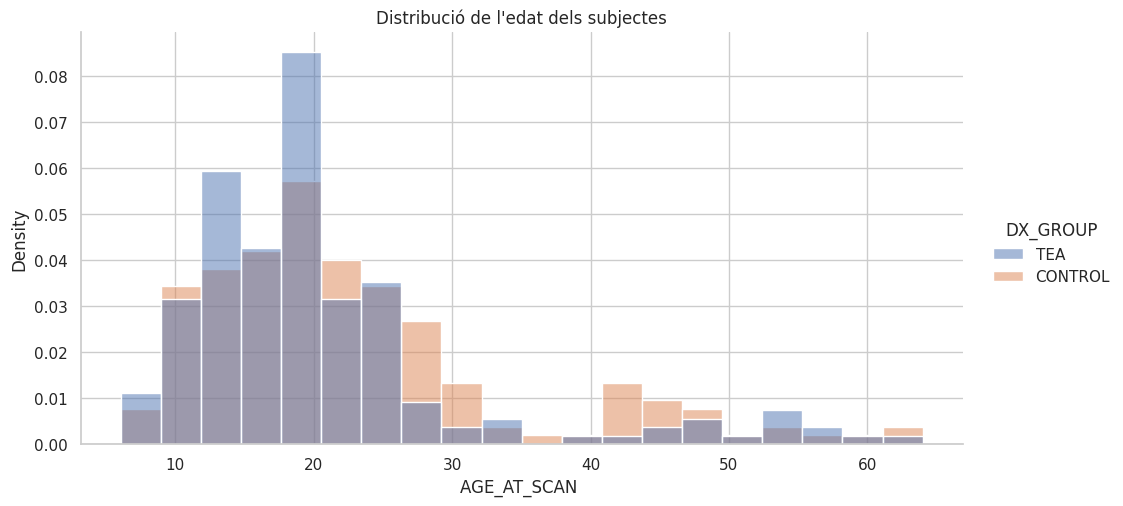

In [7]:
sns.set_style("whitegrid")
sns.displot(data=vol, x='AGE_AT_SCAN ', hue='DX_GROUP', stat="density", common_norm = False,  height=5,aspect=2.0)
plt.title('Distribució de l\'edat dels subjectes')
plt.show()

In [8]:
vol['DX_GROUP'].value_counts()

,count
DX_GROUP,
TEA,186
CONTROL,181


In [9]:
# l'anàlisi es fa en el rang d'edat de 10 a 30, harmonitzo amb un rang de dades una mica més ampli per tenir marge d'ajust
vol = vol[vol['AGE_AT_SCAN '].between(8, 35)].copy().reset_index(drop=True)
vol.shape

(322, 41)

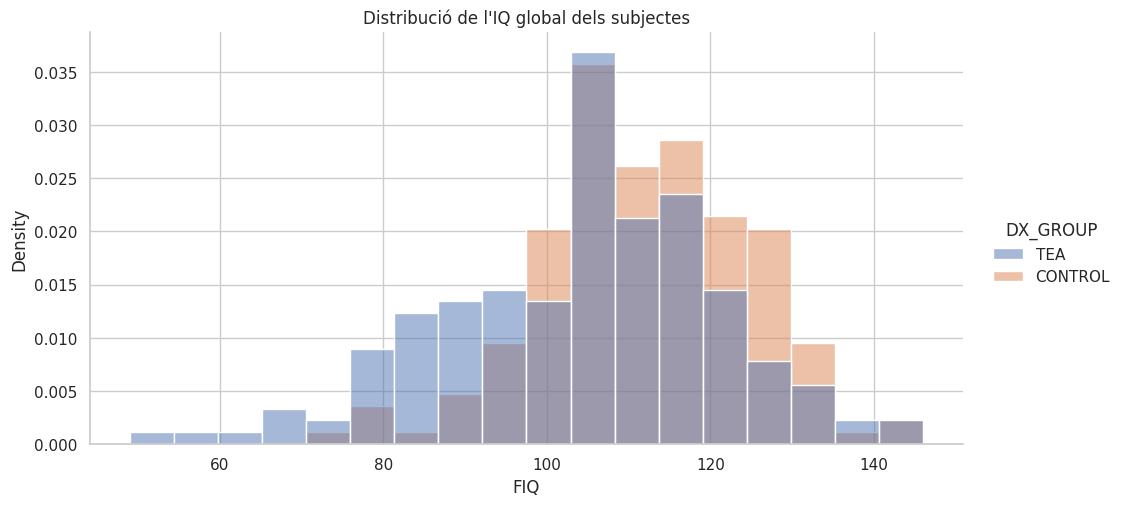

In [10]:
sns.set_style("whitegrid")
sns.displot(data=vol, x='FIQ', hue='DX_GROUP', stat="density", common_norm = False,  height=5,aspect=2.0)
plt.title('Distribució de l\'IQ global dels subjectes')
plt.show()

In [11]:
# filtro per IQ >= 70
vol = vol[vol['FIQ']>=70].copy().reset_index(drop=True)
vol.shape

(316, 41)

In [12]:
print ("TEA mean", vol[vol['DX_GROUP']== 'TEA']['FIQ'].mean())
print ("CONTROL mean", vol[vol['DX_GROUP']== 'CONTROL']['FIQ'].mean())
print ("TEA min", vol[vol['DX_GROUP']== 'TEA']['FIQ'].min())
print ("CONTROL min", vol[vol['DX_GROUP']== 'CONTROL']['FIQ'].min())
print ("TEA max", vol[vol['DX_GROUP']== 'TEA']['FIQ'].max())
print ("CONTROL max", vol[vol['DX_GROUP']== 'CONTROL']['FIQ'].max())
print ("TEA stdev", vol[vol['DX_GROUP']== 'TEA']['FIQ'].std())
print ("CONTROL stdev", vol[vol['DX_GROUP']== 'CONTROL']['FIQ'].std())



TEA mean 105.95625
CONTROL mean 111.91666666666667
TEA min 71.0
CONTROL min 71.0
TEA max 146.0
CONTROL max 146.0
TEA stdev 15.273748134478048
CONTROL stdev 12.864032545564138


In [13]:
vol['DX_GROUP'].value_counts()

,count
DX_GROUP,
TEA,160
CONTROL,156


In [14]:
vol['SEX'].value_counts()

,count
SEX,
1,258
2,58


In [15]:
vol[vol['DX_GROUP']== 'TEA']['SEX'].value_counts()

,count
SEX,
1,141
2,19


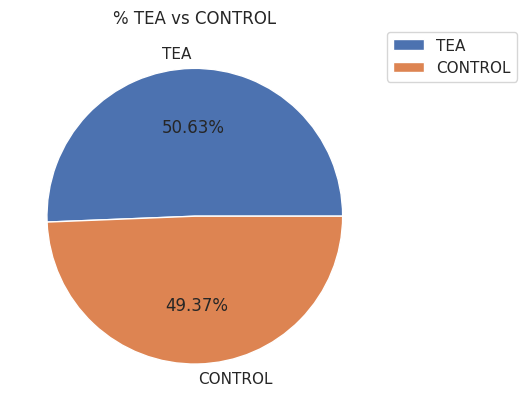

In [16]:
# Distribució de TEA vs ASD (la distribució és identica per l'arxiu amb les puntuacions de control de qualitat i amb el dels volums)
ax = vol['DX_GROUP'].value_counts().plot.pie(autopct='%.2f%%', ylabel ="" , title="% TEA vs CONTROL", legend=True)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.savefig(img_path + 'Pie_TEA_vs_Control_8_35.png')
plt.show()

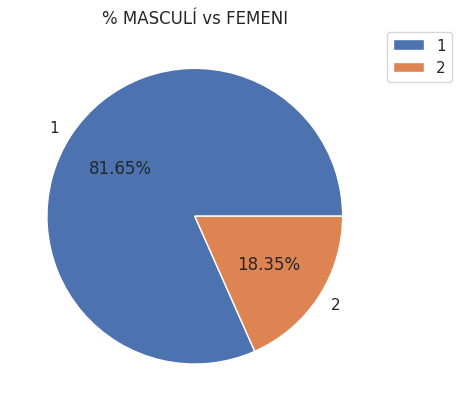

In [17]:
# Distribució de TEA vs ASD (la distribució és identica per l'arxiu amb les puntuacions de control de qualitat i amb el dels volums)
ax = vol['SEX'].value_counts().plot.pie(autopct='%.2f%%', ylabel ="" , title="% MASCULÍ vs FEMENI", legend=True)
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.savefig(img_path + 'Pie_SEXE_8_35.png')
plt.show()

In [18]:
# data frame
vol.drop(vol.columns[vol.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
vol_matrix = vol.drop(['SITE_ID', 'SUB_ID', 'DX_GROUP', 'AGE_AT_SCAN ', 'SEX', 'FIQ','subject','total intracranial'],axis=1)
# treure el %
vol_matrix = vol_matrix.div(100.0)
vol_matrix.head()

,left cerebral white matter,left cerebral cortex,left lateral ventricle,left inferior lateral ventricle,left cerebellum white matter,left cerebellum cortex,left thalamus,left caudate,left putamen,left pallidum,...,right cerebellum white matter,right cerebellum cortex,right thalamus,right caudate,right putamen,right pallidum,right hippocampus,right amygdala,right accumbens area,right ventral DC
0,0.151174,0.168721,0.004693,0.000393,0.009338,0.028171,0.004768,0.003084,0.004344,0.001099,...,0.009601,0.028558,0.004535,0.003136,0.004172,0.001082,0.002540,0.001220,0.000548,0.002717
1,0.146829,0.173178,0.004530,0.000387,0.010333,0.033204,0.005302,0.002585,0.004157,0.001053,...,0.010127,0.032630,0.004829,0.002582,0.004049,0.001049,0.003012,0.001293,0.000520,0.002828
2,0.137617,0.161185,0.005957,0.000427,0.011693,0.035686,0.004475,0.003029,0.003926,0.001110,...,0.011539,0.035904,0.004594,0.003100,0.003777,0.001184,0.002676,0.001311,0.000489,0.002886
3,0.151855,0.161603,0.007310,0.000422,0.012593,0.036282,0.004980,0.002777,0.003585,0.000993,...,0.012189,0.035338,0.005127,0.002818,0.003561,0.001071,0.002769,0.001252,0.000442,0.002984
4,0.145179,0.157614,0.009365,0.000392,0.011276,0.031351,0.004347,0.002993,0.003728,0.001044,...,0.011245,0.032033,0.004541,0.003112,0.003862,0.001028,0.003091,0.001184,0.000441,0.002790


In [19]:
covariables = ['SITE_ID','DX_GROUP', 'AGE_AT_SCAN ', 'SEX','total intracranial']
var_matrix = vol[covariables].copy()
# canviar nom de SITE_ID a SITE (neuroHarmonize necessita un camp no numèric anomenat 'SITE')
var_matrix.rename(columns={'SITE_ID':'SITE'}, inplace = True)
var_matrix['DX_GROUP'] = var_matrix['DX_GROUP'].map({'TEA': 1, 'CONTROL': 2})
var_matrix.head()

,SITE,DX_GROUP,AGE_AT_SCAN,SEX,total intracranial
0,ABIDEII-BNI_1,1,21.0,1,1607071.0
1,ABIDEII-BNI_1,1,20.0,1,1495145.1
2,ABIDEII-BNI_1,1,18.0,1,1494278.4
3,ABIDEII-BNI_1,1,21.0,1,1830696.9
4,ABIDEII-BNI_1,1,19.0,1,1830504.8


## **PAS5 - NeuroHarmonize**

Crear model amb les dades dels controls (per després aplicar harmonització)

In [20]:
#model_path = work_path + '/Model/'

###Harmonitzar ICV

Hi ha imatges de diferents escànners i amb diferents protocols d'adquisició

Afegeixo un parell de variables més perquè al executar amb una sola variable no em deixa

In [21]:
vol.columns

Index(['SITE_ID', 'SUB_ID', 'DX_GROUP', 'AGE_AT_SCAN ', 'SEX', 'FIQ',
       'subject', 'total intracranial', 'left cerebral white matter',
       'left cerebral cortex', 'left lateral ventricle',
       'left inferior lateral ventricle', 'left cerebellum white matter',
       'left cerebellum cortex', 'left thalamus', 'left caudate',
       'left putamen', 'left pallidum', '3rd ventricle', '4th ventricle',
       'brain-stem', 'left hippocampus', 'left amygdala', 'csf',
       'left accumbens area', 'left ventral DC', 'right cerebral white matter',
       'right cerebral cortex', 'right lateral ventricle',
       'right inferior lateral ventricle', 'right cerebellum white matter',
       'right cerebellum cortex', 'right thalamus', 'right caudate',
       'right putamen', 'right pallidum', 'right hippocampus',
       'right amygdala', 'right accumbens area', 'right ventral DC'],
      dtype='object')

In [22]:
# matriu dades controls
vol_matrix_ICV = vol[['total intracranial','left cerebral white matter','right cerebral white matter']].copy(True)
# taula covariables
covariables_ICV = ['SITE_ID','DX_GROUP', 'AGE_AT_SCAN ', 'SEX']
var_matrix_ICV = vol[covariables_ICV].copy(True)

# canviar nom de SITE_ID a SITE (neuroHarmonize necessita un camp no numèric anomenat 'SITE')
var_matrix_ICV.rename(columns={'SITE_ID':'SITE'}, inplace = True)
# convertir grup a numèric
var_matrix_ICV['DX_GROUP'] = var_matrix_ICV['DX_GROUP'].map({'TEA': 1, 'CONTROL': 2})

In [23]:
var_matrix_ICV.head()

,SITE,DX_GROUP,AGE_AT_SCAN,SEX
0,ABIDEII-BNI_1,1,21.0,1
1,ABIDEII-BNI_1,1,20.0,1
2,ABIDEII-BNI_1,1,18.0,1
3,ABIDEII-BNI_1,1,21.0,1
4,ABIDEII-BNI_1,1,19.0,1


In [24]:
import neuroHarmonize as nh
ICV_Model, data_Adj_ICV = harmonizationLearn(vol_matrix_ICV.to_numpy(), var_matrix_ICV)

# guardar dades ajustades a un dataframe
ICV_Adj_df = pd.DataFrame(data_Adj_ICV, columns=vol_matrix_ICV.columns)
ICV_Adj_df['SITE'] = var_matrix_ICV['SITE']

ICV_Adj_df.head()
# per si es vol guardar el model
#nh.saveHarmonizationModel(ICV_Model,model_path + 'CTRL_Model.pkl')

,total intracranial,left cerebral white matter,right cerebral white matter,SITE
0,1.596565e+06,14.828884,14.785216,ABIDEII-BNI_1
1,1.475760e+06,14.385238,14.403042,ABIDEII-BNI_1
2,1.475055e+06,13.444473,13.514513,ABIDEII-BNI_1
3,1.838163e+06,14.898534,14.945644,ABIDEII-BNI_1
4,1.838187e+06,14.217039,14.375942,ABIDEII-BNI_1


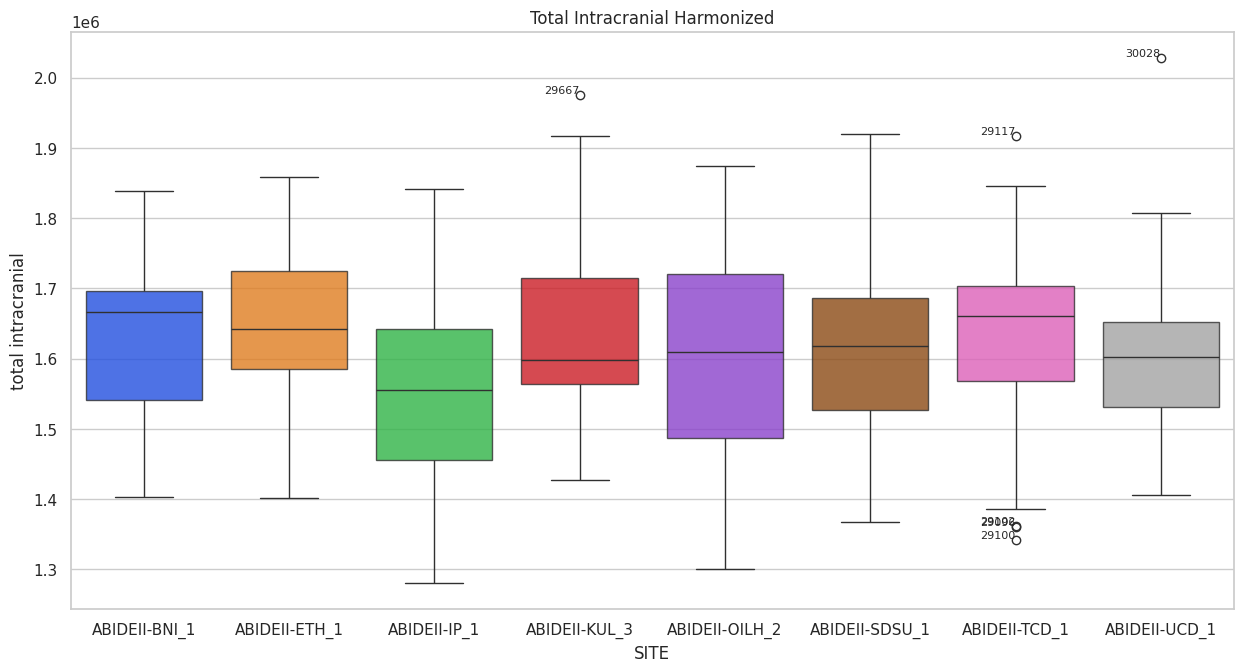

In [25]:
sns.set_style("whitegrid")
plt.figure(figsize = (15,7.5))
var = 'total intracranial'
#copiar els IDs al dataframe de dades ajustades
ICV_Adj_df['SUB_ID'] = vol['SUB_ID']
sns.boxplot(x='SITE', y=var, data=ICV_Adj_df, palette='bright', hue='SITE', boxprops=dict(alpha=0.8))

plt.title('Total Intracranial Harmonized')
# identificar outliers
for lab in ICV_Adj_df['SITE'].unique():
    cat_df = ICV_Adj_df[ICV_Adj_df['SITE'] ==  lab]

    #print (var)

    q1 = cat_df[var].quantile(0.25)
    q3 = cat_df[var].quantile(0.75)
    iqr = q3-q1
    LL = q1 - 1.5 * iqr
    HL = q3 + 1.5 * iqr

    outliers = cat_df[(cat_df[var] < LL) | (cat_df[var] > HL)]

    # anotar outliers
    for _,row in outliers.iterrows():
        plt.text(x=list(ICV_Adj_df['SITE'].unique()).index(lab), y=row[var], s=row['SUB_ID'], ha='right', va='bottom', fontsize=8)
plt.savefig(img_path + 'ICV_Labs_Harmonized.png')
plt.show()

In [26]:
harmonized_ICV_only = ICV_Adj_df[['total intracranial','left cerebral white matter','right cerebral white matter']].copy(True)

df_RAW_2_ICV = vol_matrix_ICV.copy()
df_HARMONIZED_2_ICV = harmonized_ICV_only.copy()

df_RAW_2_ICV['DX_GROUP'] = var_matrix_ICV['DX_GROUP']
df_HARMONIZED_2_ICV['DX_GROUP'] = var_matrix_ICV['DX_GROUP']

df_RAW_2_ICV['Estat'] = 'RAW'
df_HARMONIZED_2_ICV['Estat'] = 'HARMONIZED'

df_Full_Data_ICV = pd.concat([df_RAW_2_ICV, df_HARMONIZED_2_ICV], ignore_index=True)
site_info_repeated_ICV = pd.concat([var_matrix_ICV[['SITE']], var_matrix_ICV[['SITE']]], ignore_index=True)
graph_data_ICV = pd.concat([site_info_repeated_ICV, df_Full_Data_ICV], axis=1)

regions = harmonized_ICV_only.columns.tolist()
plotting_long_ICV = graph_data_ICV.melt(
    id_vars=['SITE', 'DX_GROUP','Estat'],
    value_vars=regions,
    var_name='Regio',
    value_name='Volum'
)

mean RAW = 1615046.7914556963 mean HARMONIZED = 1610540.9631148188


<Figure size 1500x10000 with 0 Axes>

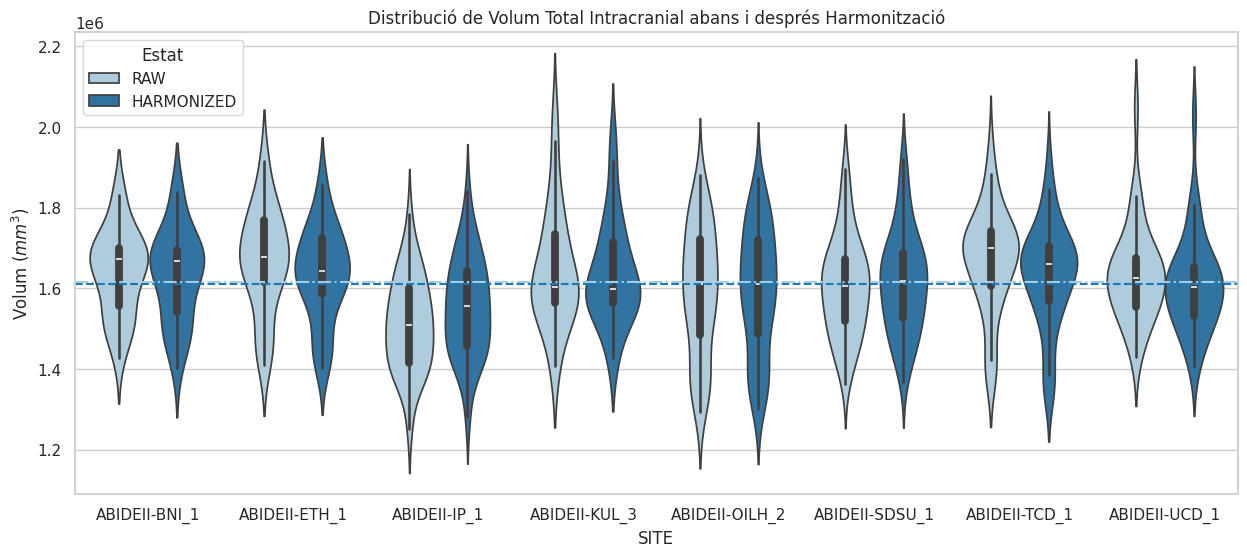

In [27]:
# mostrar l'harmonització de totes les regions cerebrals
plt.figure(figsize = (15,100))
sns.set_style("whitegrid")


plt.figure(figsize=(15, 6))

ax = sns.violinplot(
    data=plotting_long_ICV[plotting_long_ICV['Regio'] == 'total intracranial'],
    x='SITE',
    y='Volum',
    hue='Estat',
    palette='Paired'
)

mean_RAW_ICV = plotting_long_ICV[(plotting_long_ICV['Regio'] =='total intracranial') & (plotting_long_ICV['Estat'] == 'RAW')].Volum.mean()
mean_HARMONIZE_ICV = plotting_long_ICV[(plotting_long_ICV['Regio'] =='total intracranial') & (plotting_long_ICV['Estat'] == 'HARMONIZED')].Volum.mean()

print("mean RAW = " + str(mean_RAW_ICV) + " mean HARMONIZED = " + str(mean_HARMONIZE_ICV))

ax.axhline(mean_RAW_ICV, color=sns.color_palette(palette = 'Paired')[0], linestyle='-.')
ax.axhline(mean_HARMONIZE_ICV, color=sns.color_palette(palette = 'Paired')[1], linestyle='dashed')

plt.title('Distribució de Volum Total Intracranial abans i després Harmonització')
plt.ylabel('Volum ($mm^3$)')
#plt.savefig(img_path2 + str(i) + '_Harmonized.png')

plt.show()

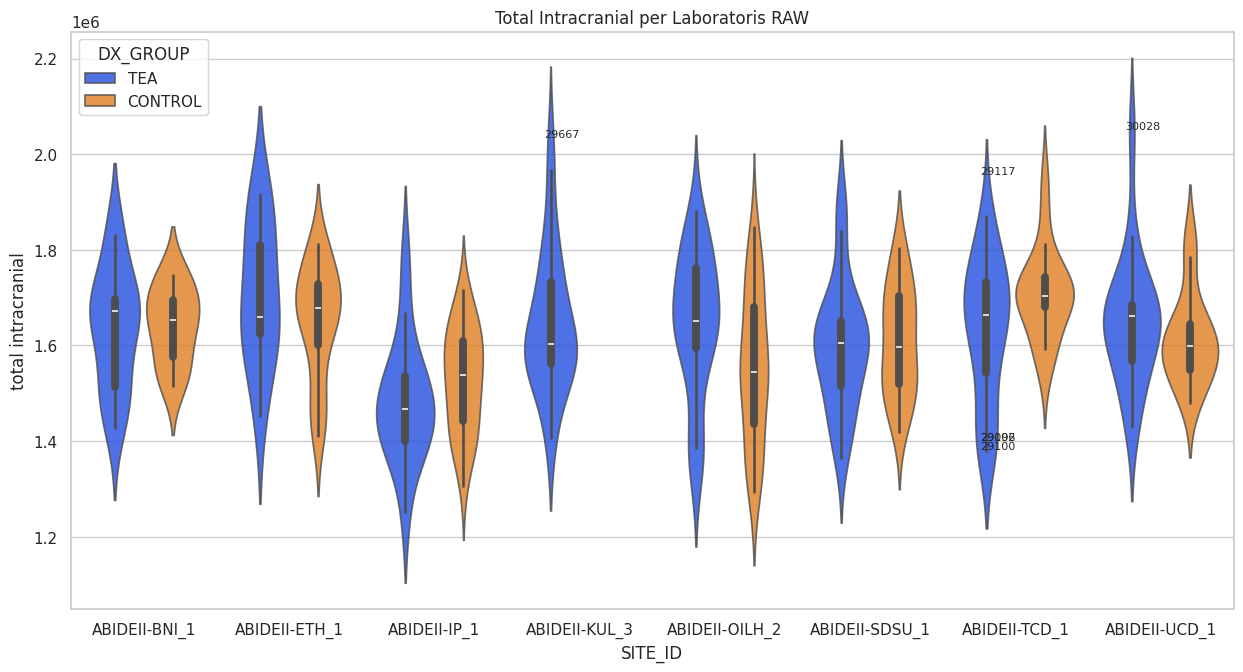

In [28]:
plt.figure(figsize = (15,7.5))
sns.set_style("whitegrid")
var = 'total intracranial'
#copiar els Grups al dataframe de dades ajustades
ICV_Adj_df['DX_GROUP'] = var_matrix_ICV['DX_GROUP'].map({1: "TEA",2:"CONTROL"})
# create grouped boxplot
sns.violinplot(x=vol['SITE_ID'], y=vol[var],
            hue = ICV_Adj_df['DX_GROUP'],
            palette='bright',
            alpha=0.8)

plt.title('Total Intracranial per Laboratoris RAW')
# identificar outliers
for lab in vol['SITE_ID'].unique():
    cat_df = vol[vol['SITE_ID'] ==  lab]

    q1 = cat_df[var].quantile(0.25)
    q3 = cat_df[var].quantile(0.75)
    iqr = q3-q1
    LL = q1 - 1.5 * iqr
    HL = q3 + 1.5 * iqr

    outliers = cat_df[(cat_df[var] < LL) | (cat_df[var] > HL)]

    # anotar outliers
    for _,row in outliers.iterrows():
        plt.text(x=list(vol['SITE_ID'].unique()).index(lab), y=row[var], s=row['SUB_ID'], ha='right', va='bottom', fontsize=8)

plt.savefig(img_path + 'ICV_Labs_Grups_RAW.png')
plt.show()

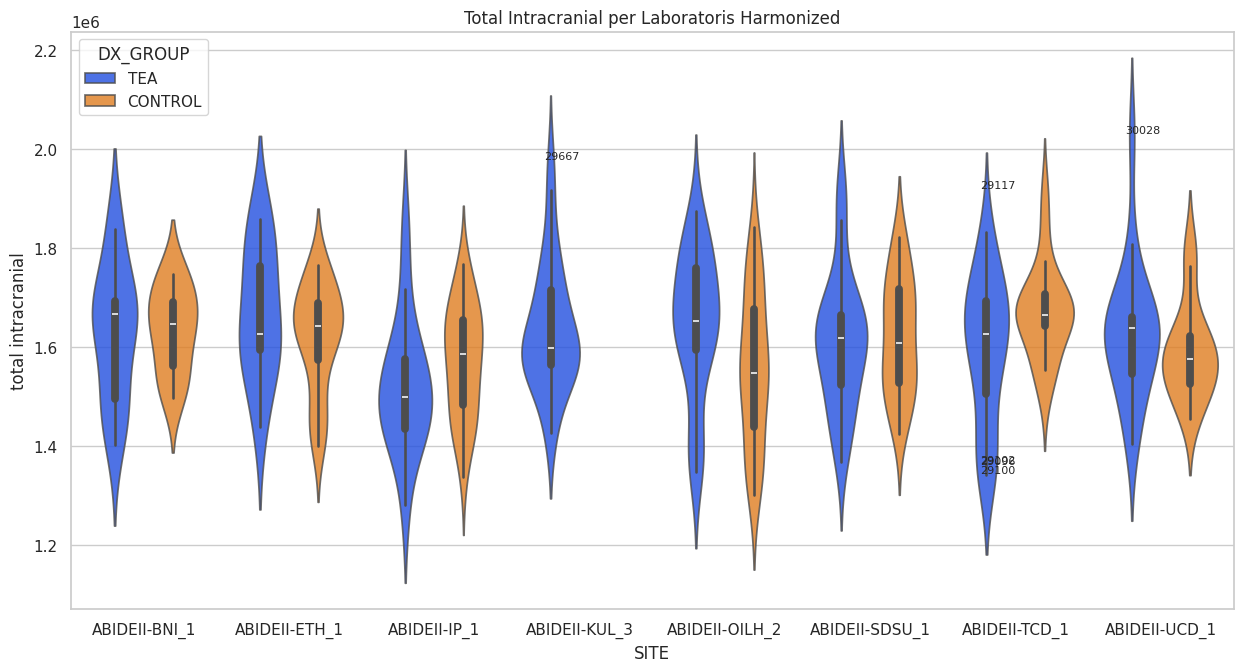

In [29]:
plt.figure(figsize = (15,7.5))
sns.set_style("whitegrid")
var = 'total intracranial'

#copiar els Grups al dataframe de dades ajustades
#ICV_Adj_df['DX_GROUP'] = var_matrix_ICV['DX_GROUP'].map({1: "TEA",2:"CONTROL"})
# create grouped boxplot
sns.violinplot(x=ICV_Adj_df['SITE'], y=ICV_Adj_df[var],
            hue = ICV_Adj_df['DX_GROUP'],
            palette='bright',
            alpha=0.8)

plt.title('Total Intracranial per Laboratoris Harmonized')
# identificar outliers
for lab in ICV_Adj_df['SITE'].unique():
    cat_df = ICV_Adj_df[ICV_Adj_df['SITE'] ==  lab]

    q1 = cat_df[var].quantile(0.25)
    q3 = cat_df[var].quantile(0.75)
    iqr = q3-q1
    LL = q1 - 1.5 * iqr
    HL = q3 + 1.5 * iqr

    outliers = cat_df[(cat_df[var] < LL) | (cat_df[var] > HL)]

    # anotar outliers
    for _,row in outliers.iterrows():
        plt.text(x=list(ICV_Adj_df['SITE'].unique()).index(lab), y=row[var], s=row['SUB_ID'], ha='right', va='bottom', fontsize=8)

plt.savefig(img_path + 'ICV_Labs_Grups_Harmonized.png')
plt.show()

### Harmonització de les regions cerebrals

In [30]:
#executar harmonization i guardar dades ajustades
model, dades_ajust = harmonizationLearn(vol_matrix.to_numpy(), var_matrix)

# guardar dades ajustades a un dataframe
dades_ajust_df = pd.DataFrame(dades_ajust, columns=vol_matrix.columns)
dades_ajust_df['SITE'] = var_matrix['SITE']

dades_ajust_df.head()

,left cerebral white matter,left cerebral cortex,left lateral ventricle,left inferior lateral ventricle,left cerebellum white matter,left cerebellum cortex,left thalamus,left caudate,left putamen,left pallidum,...,right cerebellum cortex,right thalamus,right caudate,right putamen,right pallidum,right hippocampus,right amygdala,right accumbens area,right ventral DC,SITE
0,0.148201,0.172916,0.004299,0.000391,0.008866,0.029530,0.004925,0.003081,0.004373,0.001130,...,0.029869,0.004625,0.003112,0.004221,0.001097,0.002594,0.001163,0.000535,0.002639,ABIDEII-BNI_1
1,0.143959,0.177085,0.004137,0.000384,0.009878,0.034666,0.005442,0.002604,0.004202,0.001085,...,0.034095,0.004918,0.002597,0.004102,0.001068,0.003006,0.001243,0.000511,0.002759,ABIDEII-BNI_1
2,0.135129,0.166210,0.005572,0.000428,0.011263,0.037202,0.004642,0.003030,0.003988,0.001141,...,0.037508,0.004684,0.003082,0.003839,0.001192,0.002713,0.001262,0.000484,0.002822,ABIDEII-BNI_1
3,0.149008,0.166349,0.006931,0.000424,0.012182,0.037870,0.005128,0.002787,0.003658,0.001025,...,0.037010,0.005216,0.002813,0.003623,0.001085,0.002787,0.001200,0.000442,0.002929,ABIDEII-BNI_1
4,0.142604,0.162814,0.009000,0.000391,0.010841,0.032813,0.004516,0.002994,0.003793,0.001075,...,0.033546,0.004630,0.003090,0.003918,0.001046,0.003066,0.001127,0.000441,0.002720,ABIDEII-BNI_1


### Grafics

In [31]:
harmonized_volumes_only = dades_ajust_df.iloc[:, :32].copy()

df_RAW_2 = vol_matrix.copy()
df_HARMONIZED_2 = harmonized_volumes_only.copy()

df_RAW_2['DX_GROUP'] = var_matrix['DX_GROUP']
df_HARMONIZED_2['DX_GROUP'] = var_matrix['DX_GROUP']

df_RAW_2['Estat'] = 'RAW'
df_HARMONIZED_2['Estat'] = 'HARMONIZED'

df_Full_Data = pd.concat([df_RAW_2, df_HARMONIZED_2], ignore_index=True)
site_info_repeated = pd.concat([var_matrix[['SITE']], var_matrix[['SITE']]], ignore_index=True)
graph_data = pd.concat([site_info_repeated, df_Full_Data], axis=1)

regions = harmonized_volumes_only.columns.tolist()
plotting_long = graph_data.melt(
    id_vars=['SITE', 'DX_GROUP','Estat'],
    value_vars=regions,
    var_name='Regio',
    value_name='Volum'
)

In [32]:
# mostrar l'harmonització de totes les regions cerebrals
plt.figure(figsize = (15,100))
sns.set_style("whitegrid")

for i in list(regions):
    plt.figure(figsize=(15, 7.5))

    ax = sns.violinplot(
        data=plotting_long[plotting_long['Regio'] == str(i)],
        x='SITE',
        y='Volum',
        hue='Estat',
        palette='Paired'
    )

    mean_RAW = plotting_long[(plotting_long['Regio'] == str(i)) & (plotting_long['Estat'] == 'RAW')].Volum.mean()
    mean_HARMONIZE = plotting_long[(plotting_long['Regio'] == str(i)) & (plotting_long['Estat'] == 'HARMONIZED')].Volum.mean()

    print("mean RAW = " + str(mean_RAW) + " mean HARMONIZED = " + str(mean_HARMONIZE))

    ax.axhline(mean_RAW, color=sns.color_palette(palette = 'Paired')[0], linestyle='-.')
    ax.axhline(mean_HARMONIZE, color=sns.color_palette(palette = 'Paired')[1], linestyle='dashed')

    plt.title('Distribució de ' + str(i) + ' abans i després Harmonització')
    plt.ylabel('Volum ($mm^3$)')
    plt.savefig(img_path + str(i) + '_Harmonized.png')

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

##PAS6: Harmonized - guardar resultats a CSV

In [33]:
# afegir paràmetres que falten
matrix_adj_ICV = ICV_Adj_df
matrix_adj_ICV['SUB_ID'] = vol['SUB_ID']
matrix_adj_ICV['DX_GROUP'] = vol['DX_GROUP']
matrix_adj_ICV['AGE_AT_SCAN'] = vol['AGE_AT_SCAN ']
matrix_adj_ICV['SEX'] = vol['SEX']
matrix_adj_ICV['FIQ'] = vol['FIQ']
matrix_adj_ICV['SITE'] = vol['SITE_ID']
matrix_adj_ICV.columns

Index(['total intracranial', 'left cerebral white matter',
       'right cerebral white matter', 'SITE', 'SUB_ID', 'DX_GROUP',
       'AGE_AT_SCAN', 'SEX', 'FIQ'],
      dtype='object')

In [34]:
matrix_adj_ICV.head()

,total intracranial,left cerebral white matter,right cerebral white matter,SITE,SUB_ID,DX_GROUP,AGE_AT_SCAN,SEX,FIQ
0,1.596565e+06,14.828884,14.785216,ABIDEII-BNI_1,29028,TEA,21.0,1,94.0
1,1.475760e+06,14.385238,14.403042,ABIDEII-BNI_1,29029,TEA,20.0,1,97.0
2,1.475055e+06,13.444473,13.514513,ABIDEII-BNI_1,29030,TEA,18.0,1,111.0
3,1.838163e+06,14.898534,14.945644,ABIDEII-BNI_1,29031,TEA,21.0,1,97.0
4,1.838187e+06,14.217039,14.375942,ABIDEII-BNI_1,29037,TEA,19.0,1,139.0


In [35]:
# guardar CSV amb les dades
matrix_adj_ICV.to_csv(work_path + '/CSV/harmonized_ICV_data.csv')

In [36]:
# afegir paràmetres que falten
matrix_adj = dades_ajust_df
matrix_adj['SUB_ID'] = vol['SUB_ID']
matrix_adj['DX_GROUP'] = vol['DX_GROUP']
matrix_adj['AGE_AT_SCAN'] = vol['AGE_AT_SCAN ']
matrix_adj['SEX'] = vol['SEX']
matrix_adj['FIQ'] = vol['FIQ']
matrix_adj['SITE'] = vol['SITE_ID']
matrix_adj.columns

Index(['left cerebral white matter', 'left cerebral cortex',
       'left lateral ventricle', 'left inferior lateral ventricle',
       'left cerebellum white matter', 'left cerebellum cortex',
       'left thalamus', 'left caudate', 'left putamen', 'left pallidum',
       '3rd ventricle', '4th ventricle', 'brain-stem', 'left hippocampus',
       'left amygdala', 'csf', 'left accumbens area', 'left ventral DC',
       'right cerebral white matter', 'right cerebral cortex',
       'right lateral ventricle', 'right inferior lateral ventricle',
       'right cerebellum white matter', 'right cerebellum cortex',
       'right thalamus', 'right caudate', 'right putamen', 'right pallidum',
       'right hippocampus', 'right amygdala', 'right accumbens area',
       'right ventral DC', 'SITE', 'SUB_ID', 'DX_GROUP', 'AGE_AT_SCAN', 'SEX',
       'FIQ'],
      dtype='object')

In [37]:
dades_ajust_df.head()

,left cerebral white matter,left cerebral cortex,left lateral ventricle,left inferior lateral ventricle,left cerebellum white matter,left cerebellum cortex,left thalamus,left caudate,left putamen,left pallidum,...,right hippocampus,right amygdala,right accumbens area,right ventral DC,SITE,SUB_ID,DX_GROUP,AGE_AT_SCAN,SEX,FIQ
0,0.148201,0.172916,0.004299,0.000391,0.008866,0.029530,0.004925,0.003081,0.004373,0.001130,...,0.002594,0.001163,0.000535,0.002639,ABIDEII-BNI_1,29028,TEA,21.0,1,94.0
1,0.143959,0.177085,0.004137,0.000384,0.009878,0.034666,0.005442,0.002604,0.004202,0.001085,...,0.003006,0.001243,0.000511,0.002759,ABIDEII-BNI_1,29029,TEA,20.0,1,97.0
2,0.135129,0.166210,0.005572,0.000428,0.011263,0.037202,0.004642,0.003030,0.003988,0.001141,...,0.002713,0.001262,0.000484,0.002822,ABIDEII-BNI_1,29030,TEA,18.0,1,111.0
3,0.149008,0.166349,0.006931,0.000424,0.012182,0.037870,0.005128,0.002787,0.003658,0.001025,...,0.002787,0.001200,0.000442,0.002929,ABIDEII-BNI_1,29031,TEA,21.0,1,97.0
4,0.142604,0.162814,0.009000,0.000391,0.010841,0.032813,0.004516,0.002994,0.003793,0.001075,...,0.003066,0.001127,0.000441,0.002720,ABIDEII-BNI_1,29037,TEA,19.0,1,139.0


In [38]:
# guardar CSV amb les dades
dades_ajust_df.to_csv(harm_Path)